# Начальная конфигурация

In [ ]:
import os
import re
import json
import warnings
from collections import Counter
from typing import List, Tuple, Optional
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

from tqdm import tqdm

import config
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# стоп-слова
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
STOP_WORDS = set(ENGLISH_STOP_WORDS)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed: int = config.RANDOM_SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

## Загрузка и изучение данных из датаеста

In [44]:
df = pd.read_csv(config.RAW_DATA_PATH)

print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

print(f"\nClass distribution:")
class_counts = df['label'].value_counts()
for label, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

print("\nExample of texts:")
print("-" * 70)
for label in df['label'].unique():
    sample = df[df['label'] == label].sample(1).iloc[0]
    text = sample['text'][:150] + ".." if len(sample['text']) > 150 else sample['text']
    print(f"\n{label.upper()}:")
    print(f"  Text: {text}")
    if pd.notna(sample['author']) and sample['author']:
        print(f"  Author: {sample['author']}")
    if pd.notna(sample['category']) and sample['category']:
        print(f"  Category: {sample['category']}")

Shape: (2319, 5)

Columns: ['text', 'label', 'author', 'category', 'original_id']

Data types:
text           object
label          object
author         object
category       object
original_id    object
dtype: object

Missing values:
text              0
label             0
author          319
category       2000
original_id       0
dtype: int64

Class distribution:
  quote: 1000 (43.1%)
  fact: 1000 (43.1%)
  joke: 319 (13.8%)

Example of texts:
----------------------------------------------------------------------

QUOTE:
  Text: Create each day anew.
  Author: Morihei Ueshiba

FACT:
  Text: An eighteenth-century German named Matthew Birchinger, known as "the little man of Nuremberg," played four musical instruments including the bagpipes,..
  Author: djtech.net

JOKE:
  Text: To whoever stole my copy of Microsoft Office, I will find you. You have my Word!
  Category: Pun


## Предварительный анализ данных (EDA)

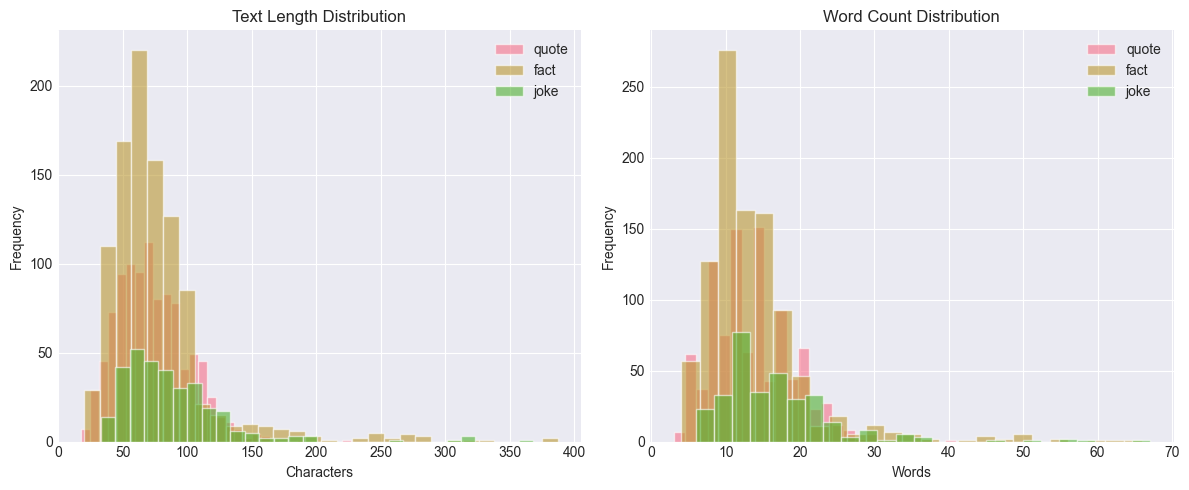

In [45]:
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
for label in df['label'].unique():
    subset = df[df['label'] == label]['text_length']
    ax1.hist(subset, bins=30, alpha=0.6, label=label)
ax1.set_title('Text Length Distribution')
ax1.set_xlabel('Characters')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
for label in df['label'].unique():
    subset = df[df['label'] == label]['word_count']
    ax2.hist(subset, bins=25, alpha=0.6, label=label)
ax2.set_title('Word Count Distribution')
ax2.set_xlabel('Words')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()

### Облака слов по классам (WordCloud)

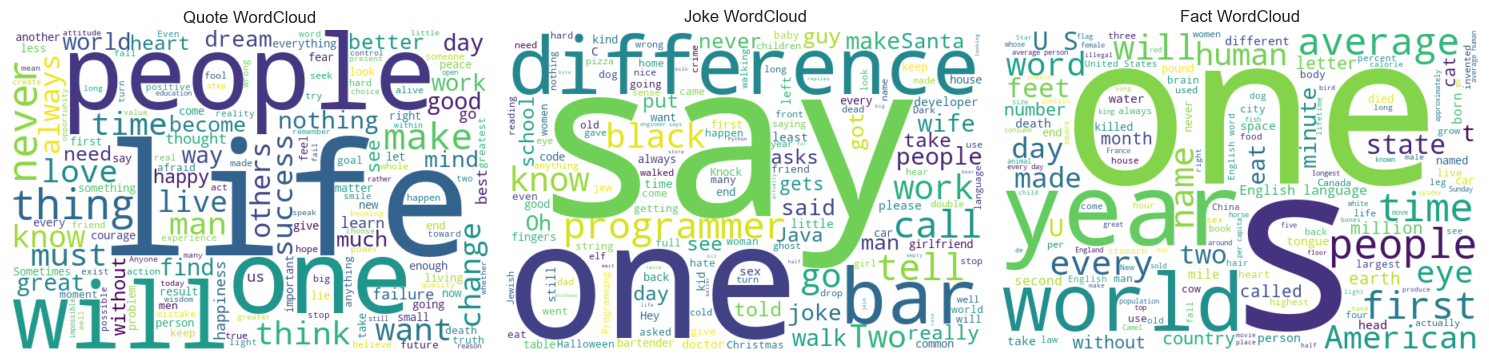

In [46]:
try:
    from wordcloud import WordCloud

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for idx, (label, ax) in enumerate(zip(['quote', 'joke', 'fact'], axes)):
        texts = ' '.join(df[df['label'] == label]['text'].astype(str).tolist())
        wc = WordCloud(
            width=600,
            height=400,
            background_color='white',
            max_words=150,
            colormap='viridis'
        ).generate(texts)
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'{label.capitalize()} WordCloud')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"WordCloud generation skipped: {e}")

## Обработка текстов и построение словаря

In [47]:
class TextPreprocessor:
    def __init__(self,
                 lowercase: bool = True,
                 remove_urls: bool = True,
                 remove_special: bool = True,
                 remove_numbers: bool = False,
                 remove_stopwords: bool = True):
        self.lowercase = lowercase
        self.remove_urls = remove_urls
        self.remove_special = remove_special
        self.remove_numbers = remove_numbers
        self.remove_stopwords = remove_stopwords

        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.email_pattern = re.compile(r'\S+@\S+')
        self.mention_pattern = re.compile(r'@\w+')
        self.hashtag_pattern = re.compile(r'#\w+')

        if remove_numbers:
            self.special_char_pattern = re.compile(r'[^a-zA-Z\s]')
        else:
            self.special_char_pattern = re.compile(r'[^a-zA-Z0-9\s\'\-]')

        self.whitespace_pattern = re.compile(r'\s+')

    def clean_text(self, text: str) -> str:
        if not isinstance(text, str):
            return ""

        # Lowercase
        if self.lowercase:
            text = text.lower()

        # Удаление ссылок
        if self.remove_urls:
            text = self.url_pattern.sub(' ', text)
            text = self.email_pattern.sub(' ', text)

        # Удаление хэштегов и упоминаний
        text = self.mention_pattern.sub(' ', text)
        text = self.hashtag_pattern.sub(' ', text)

        # Удаление мусорных символов
        if self.remove_special:
            text = self.special_char_pattern.sub(' ', text)

        # Починка пробелов
        text = self.whitespace_pattern.sub(' ', text)

        return text.strip()

    def tokenize(self, text: str) -> List[str]:
        return text.split()

    def preprocess(self, text: str) -> List[str]:
        cleaned = self.clean_text(text)
        tokens = self.tokenize(cleaned)
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in STOP_WORDS]
        return tokens

preprocessor = TextPreprocessor()
df['tokens'] = df['text'].apply(preprocessor.preprocess)
df['token_count'] = df['tokens'].apply(len)

print(f"Preprocessing is done. Average tokens per text: {df['token_count'].mean():.1f}")

Preprocessing is done. Average tokens per text: 6.7


### Построение словаря

In [48]:
class Vocabulary:
    def __init__(self, max_size: int = 5000, min_freq: int = 2):
        self.max_size = max_size
        self.min_freq = min_freq

        # Токены
        self.pad_token = config.PAD_TOKEN
        self.unk_token = config.UNK_TOKEN
        self.pad_idx = config.PAD_IDX
        self.unk_idx = config.UNK_IDX

        # Инициализация словарей
        self.word2idx = {
            self.pad_token: self.pad_idx,
            self.unk_token: self.unk_idx
        }
        self.idx2word = {
            self.pad_idx: self.pad_token,
            self.unk_idx: self.unk_token
        }

        self.word_freq = Counter()

    def build(self, token_lists: List[List[str]]) -> 'Vocabulary':
        # Частоты
        for tokens in tqdm(token_lists, desc="Counting words"):
            self.word_freq.update(tokens)

        valid_words = [
            word for word, freq in self.word_freq.most_common()
            if freq >= self.min_freq
        ]

        # Ограничение по размеру
        valid_words = valid_words[:self.max_size - len(self.word2idx)]

        # Заполнение
        for word in valid_words:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        print(f"Vocabulary built: {len(self)} words")
        print(f"Total unique words: {len(self.word_freq)}")         # +2 для спецтокенов
        print(f"Words filtered out: {len(self.word_freq) - len(self) + 2}")

        return self

    def encode(self, tokens: List[str]) -> List[int]:
        return [self.word2idx.get(token, self.unk_idx) for token in tokens]

    def decode(self, indices: List[int]) -> List[str]:
        return [self.idx2word.get(idx, self.unk_token) for idx in indices]

    def __len__(self) -> int:
        return len(self.word2idx)

    def save(self, filepath: str):
        os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)

        data = {
            'word2idx': self.word2idx,
            'idx2word': {str(k): v for k, v in self.idx2word.items()},
            'word_freq': dict(self.word_freq.most_common(1000))
        }
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
        print(f"Vocabulary saved to {filepath}")

vocab = Vocabulary(max_size=config.MAX_VOCAB_SIZE, min_freq=config.MIN_WORD_FREQ)
vocab.build(df['tokens'].tolist())

vocab.save(config.VOCAB_PATH)

print("-"*70)
print("Vocabulary Stats")
print("-"*70)
print(f"Vocabulary size: {len(vocab)}")
print(f"Coverage: {len(vocab)/len(vocab.word_freq)*100:.1f}% of unique words")

# Топ частых слов (20)
print("\nTop 20 most common words:")
for i, (word, freq) in enumerate(vocab.word_freq.most_common(20), 1):
    print(f"  {i:2d}. {word:15s} : {freq:5d}")

Counting words: 100%|██████████| 2319/2319 [00:00<00:00, 775212.48it/s]

Vocabulary built: 2366 words
Total unique words: 5445
Words filtered out: 3081
Vocabulary saved to data\vocab.json
----------------------------------------------------------------------
Vocabulary Stats
----------------------------------------------------------------------
Vocabulary size: 2366
Coverage: 43.5% of unique words

Top 20 most common words:
   1. people          :   148
   2. s               :   116
   3. life            :   111
   4. world           :    94
   5. don't           :    93
   6. day             :    70
   7. man             :    63
   8. time            :    63
   9. average         :    63
  10. make            :    62
  11. 000             :    58
  12. like            :    55
  13. things          :    53
  14. does            :    48
  15. it's            :    48
  16. just            :    48
  17. know            :    47
  18. want            :    47
  19. think           :    45
  20. -               :    44


## Подготовка датасетов и DataLoader'ов

In [49]:
class TextDataset(Dataset):
    def __init__(self,
                 texts: List[List[str]],
                 labels: List[int],
                 vocab: Vocabulary,
                 max_length: int = 150):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, int]:
        tokens = self.texts[idx][:self.max_length]
        label = self.labels[idx]

        # Кодирование токенов
        indices = self.vocab.encode(tokens)

        return (
            torch.tensor(indices, dtype=torch.long),
            len(indices),
            label
        )


def collate_fn(batch: List[Tuple]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    sequences, lengths, labels = zip(*batch)

    # Наполнение последовательностей
    padded = pad_sequence(sequences, batch_first=True, padding_value=config.PAD_IDX)

    # Конвертация в тензоры
    lengths = torch.tensor(lengths, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)

    return padded, lengths, labels

df['label'] = df['label'].str.lower().str.strip()
label_mapping = config.LABEL_TO_IDX
y_raw = df['label'].map(label_mapping)
if y_raw.isna().any():
    raise ValueError(f"Unmapped labels present: {df[y_raw.isna()]['label'].unique()}")

y = y_raw.tolist()
X = df['tokens'].tolist()

# Разбиение на train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=config.TEST_RATIO,
    random_state=config.RANDOM_SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=config.VAL_RATIO / (config.TRAIN_RATIO + config.VAL_RATIO),
    random_state=config.RANDOM_SEED,
    stratify=y_temp
)

train_dataset = TextDataset(X_train, y_train, vocab, config.MAX_SEQ_LENGTH)
val_dataset = TextDataset(X_val, y_val, vocab, config.MAX_SEQ_LENGTH)
test_dataset = TextDataset(X_test, y_test, vocab, config.MAX_SEQ_LENGTH)

train_loader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE,
    shuffle=True, collate_fn=collate_fn, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=config.BATCH_SIZE,
    shuffle=False, collate_fn=collate_fn, num_workers=0
)
test_loader = DataLoader(
    test_dataset, batch_size=config.BATCH_SIZE,
    shuffle=False, collate_fn=collate_fn, num_workers=0
)

print(f"\nDataLoader batches:")
print(f"Train: {len(train_loader)}")
print(f"Val:   {len(val_loader)}")
print(f"Test:  {len(test_loader)}")


DataLoader batches:
Train: 26
Val:   6
Test:  6


## Определение модели

In [50]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        # (batch, seq_len, hidden_size)
        attention_scores = self.attention(lstm_output).squeeze(-1)  # (batch, seq_len)

        # Маскировка паддингов
        mask = torch.arange(lstm_output.size(1)).unsqueeze(0) < lengths.unsqueeze(1)
        attention_scores = attention_scores.masked_fill(~mask.to(lstm_output.device), -float('inf'))

        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)

        return weighted


class TextClassifier(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embedding_dim: int = 128,
                 hidden_dim: int = 256,
                 num_layers: int = 2,
                 num_classes: int = 3,
                 bidirectional: bool = True,
                 dropout_rate: float = 0.4,
                 fc_dims: Optional[List[int]] = None,
                 use_attention: bool = True):
        super().__init__()

        self.use_attention = use_attention
        self.num_directions = 2 if bidirectional else 1

        # Эмбеддинги
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=config.PAD_IDX
        )
        # Dropout на эмбеддинги
        self.embedding_dropout = nn.Dropout(p=0.2)

        # LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Attention
        lstm_output_size = hidden_dim * self.num_directions
        if use_attention:
            self.attention = AttentionLayer(lstm_output_size)

        # Нормализация батчей
        self.batch_norm = nn.BatchNorm1d(lstm_output_size)

        fc_layers = []
        prev_dim = lstm_output_size

        if fc_dims is None:
            fc_dims = [256, 128, 64]
        for fc_dim in fc_dims:
            fc_layers.extend([
                nn.Linear(prev_dim, fc_dim),
                nn.BatchNorm1d(fc_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = fc_dim

        self.fc = nn.Sequential(*fc_layers)

        self.output = nn.Linear(prev_dim, num_classes)

        self.last_hidden = None

    def forward(self, x: torch.Tensor, lengths: torch.Tensor,
                extract_embedding: bool = False) -> torch.Tensor:
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)

        # LSTM
        packed = pack_padded_sequence(
            embedded, lengths.cpu().clamp(min=1),
            batch_first=True, enforce_sorted=False
        )

        packed_output, (hidden, _) = self.lstm(packed)
        lstm_output, _ = pad_packed_sequence(packed_output, batch_first=True)

        if self.use_attention:
            representation = self.attention(lstm_output, lengths)
        else:
            if self.lstm.bidirectional:
                representation = torch.cat([hidden[-2], hidden[-1]], dim=1)
            else:
                representation = hidden[-1]

        # Нормализация батчей
        representation = self.batch_norm(representation)

        # FC
        features = self.fc(representation)

        if extract_embedding:
            self.last_hidden = features.detach().cpu()

        logits = self.output(features)

        return logits

    def get_embedding(self) -> Optional[torch.Tensor]:
        return self.last_hidden


model = TextClassifier(
    vocab_size=len(vocab),
    embedding_dim=config.EMBEDDING_DIM,
    hidden_dim=config.HIDDEN_DIM,
    num_layers=config.NUM_LSTM_LAYERS,
    num_classes=config.NUM_CLASSES,
    bidirectional=config.BIDIRECTIONAL,
    dropout_rate=config.DROPOUT_RATE,
    fc_dims=config.FC_HIDDEN_DIMS,
    use_attention=True
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Architecture:
TextClassifier(
  (embedding): Embedding(2366, 128, padding_idx=0)
  (embedding_dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (attention): AttentionLayer(
    (attention): Linear(in_features=512, out_features=1, bias=True)
  )
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=64, out_features=3, bias=True)
)

Total parameters: 1,169,412
Trainable parameters: 1,169,412


### Обучение, валидация и сохранение артефактов

In [51]:
class ModelTrainer:
    def __init__(self, model, device, learning_rate=1e-3, weight_decay=1e-5):
        self.model = model
        self.device = device

        # Loss и optimizer
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.optimizer = optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        # Оценивающий планировщик
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=3
        )

        # TensorBoard
        os.makedirs(config.TENSORBOARD_LOG_DIR, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.writer = SummaryWriter(f'{config.TENSORBOARD_LOG_DIR}/exp_{timestamp}')

        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_model_state = None

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc="Training", leave=False)
        for batch in pbar:
            sequences, lengths, labels = [x.to(self.device) for x in batch]

            # Прямой
            self.optimizer.zero_grad()
            outputs = self.model(sequences, lengths)
            loss = self.criterion(outputs, labels)

            # Обратный
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            # Статы
            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        return total_loss / total, correct / total

    @torch.no_grad()
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        for batch in loader:
            sequences, lengths, labels = [x.to(self.device) for x in batch]

            outputs = self.model(sequences, lengths)
            loss = self.criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        return total_loss / total, correct / total

    def train(self, train_loader, val_loader, num_epochs=25, patience=5):
        print(f"  Device: {self.device}")
        print(f"  Epochs: {num_epochs}")
        print(f"  Early stopping patience: {patience}")
        print("-" * 70)

        for epoch in range(num_epochs):
            # Train
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validate
            val_loss, val_acc = self.evaluate(val_loader)

            # Update планировщика
            old_lr = self.optimizer.param_groups[0]['lr']
            self.scheduler.step(val_loss)
            new_lr = self.optimizer.param_groups[0]['lr']
            if new_lr != old_lr:
                print(f"  Learning rate reduced: {old_lr:.2e} -> {new_lr:.2e}")

            # TensorBoard лог
            self.writer.add_scalars('Loss', {
                'train': train_loss, 'val': val_loss
            }, epoch)
            self.writer.add_scalars('Accuracy', {
                'train': train_acc, 'val': val_acc
            }, epoch)

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1:2d}/{num_epochs}")
            print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
            print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.best_model_state = self.model.state_dict().copy()
                print("^ New best model saved")
            else:
                self.patience_counter += 1
                print(f"  Patience: {self.patience_counter}/{patience}")
                if self.patience_counter >= patience:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    break
            print()

        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)
            print("Loaded best model weights")

        self.writer.close()
        return self.history

trainer = ModelTrainer(
    model, device,
    learning_rate=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

history = trainer.train(
    train_loader, val_loader,
    num_epochs=config.NUM_EPOCHS,
    patience=config.EARLY_STOPPING_PATIENCE
)

config_dict = {
    'EMBEDDING_DIM': config.EMBEDDING_DIM,
    'HIDDEN_DIM': config.HIDDEN_DIM,
    'NUM_LSTM_LAYERS': config.NUM_LSTM_LAYERS,
    'NUM_CLASSES': config.NUM_CLASSES,
    'BIDIRECTIONAL': config.BIDIRECTIONAL,
    'DROPOUT_RATE': config.DROPOUT_RATE,
    'FC_HIDDEN_DIMS': config.FC_HIDDEN_DIMS,
    'MAX_SEQ_LENGTH': config.MAX_SEQ_LENGTH,
    'LABEL_TO_IDX': config.LABEL_TO_IDX,
    'IDX_TO_LABEL': config.IDX_TO_LABEL,
    'PAD_IDX': config.PAD_IDX,
    'UNK_IDX': config.UNK_IDX,
}

vocab_dict = {
    'word2idx': vocab.word2idx,
    'idx2word': vocab.idx2word,
    'pad_idx': vocab.pad_idx,
    'unk_idx': vocab.unk_idx,
}

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab_dict,
    'history': history,
    'config': config_dict,
    'vocab_size': len(vocab),
}, config.MODEL_PATH)

print(f"Best model saved to {config.MODEL_PATH}")

  Device: cpu
  Epochs: 8
  Early stopping patience: 2
----------------------------------------------------------------------


Epoch  1/8
  Train - Loss: 1.0724, Acc: 0.4812
  Val   - Loss: 1.0210, Acc: 0.6207
^ New best model saved



Epoch  2/8
  Train - Loss: 0.9203, Acc: 0.6131
  Val   - Loss: 0.8674, Acc: 0.6523
^ New best model saved



Epoch  3/8
  Train - Loss: 0.8163, Acc: 0.6895
  Val   - Loss: 0.7929, Acc: 0.6954
^ New best model saved



Epoch  4/8
  Train - Loss: 0.7491, Acc: 0.7295
  Val   - Loss: 0.7573, Acc: 0.7270
^ New best model saved



Epoch  5/8
  Train - Loss: 0.6778, Acc: 0.7874
  Val   - Loss: 0.7204, Acc: 0.7615
^ New best model saved



Epoch  6/8
  Train - Loss: 0.6148, Acc: 0.8318
  Val   - Loss: 0.6911, Acc: 0.7787
^ New best model saved



Epoch  7/8
  Train - Loss: 0.5575, Acc: 0.8774
  Val   - Loss: 0.6698, Acc: 0.8075
^ New best model saved



Epoch  8/8
  Train - Loss: 0.5290, Acc: 0.8971
  Val   - Loss: 0.7022, Acc: 0.7759
  Patience: 1/2

Loaded best model weights
Best model saved to data\model.pt


## Визуализация истории обучения и проверка переобучения

Final Performance:
  Train Accuracy: 0.8971
  Val Accuracy: 0.7759
  Gap: 0.1212


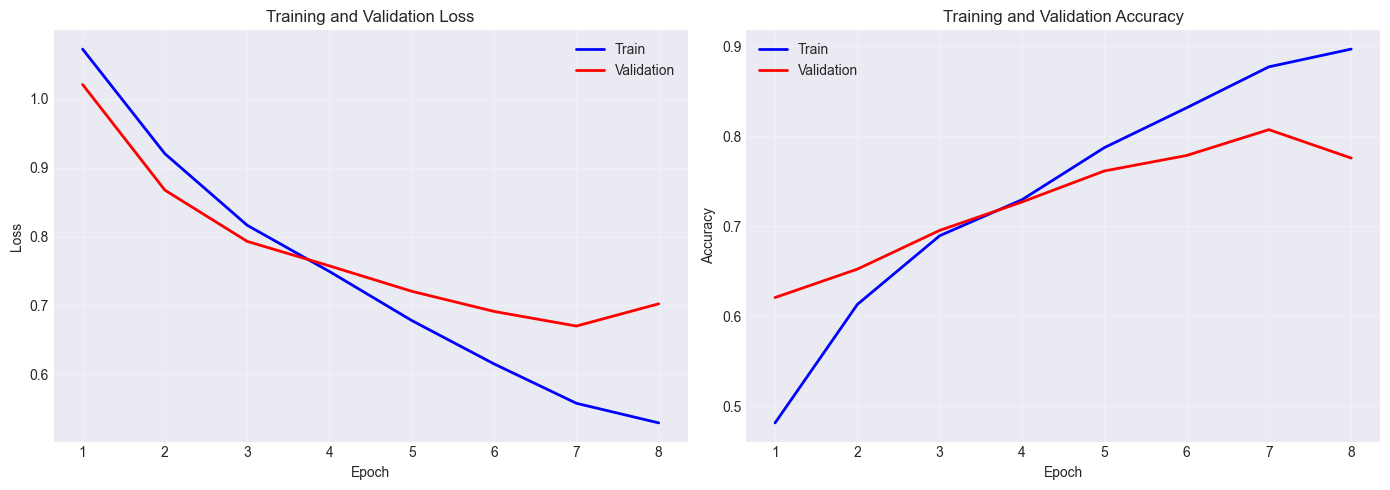

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
epochs = range(1, len(history['train_loss']) + 1)

ax1 = axes[0]
ax1.plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
ax1.plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Точность
ax2 = axes[1]
ax2.plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
ax2.plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Переобучение
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
print(f"Final Performance:\n  Train Accuracy: {final_train_acc:.4f}\n  Val Accuracy: {final_val_acc:.4f}\n  Gap: {final_train_acc - final_val_acc:.4f}")

### Оценка на train/test и агрегированные метрики

In [53]:
@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_embeddings = []

    for batch in tqdm(loader, desc="Evaluating"):
        sequences, lengths, labels = [x.to(device) for x in batch]

        outputs = model(sequences, lengths, extract_embedding=True)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        embedding = model.get_embedding()
        if embedding is not None:
            all_embeddings.append(embedding)

    embeddings = torch.cat(all_embeddings, dim=0).numpy() if all_embeddings else None

    return np.array(all_preds), np.array(all_labels), embeddings

# Делаем предсказания
train_preds, train_labels, train_embeddings = get_predictions(model, train_loader, device)
test_preds, test_labels, test_embeddings = get_predictions(model, test_loader, device)

# Метрики
train_acc = accuracy_score(train_labels, train_preds)
test_acc = accuracy_score(test_labels, test_preds)

train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
    train_labels, train_preds, average='weighted'
)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='weighted'
)

print("Evaluation Metrics")
print("-" * 70)

metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Train': [train_acc, train_prec, train_rec, train_f1],
    'Test': [test_acc, test_prec, test_rec, test_f1]
}).round(4)
print(metrics_table.to_string(index=False))

print("\n" + "-" * 70)
print("Detailed report for Test Set:")
print("-" * 70)
print(classification_report(test_labels, test_preds, target_names=[config.IDX_TO_LABEL[i] for i in range(config.NUM_CLASSES)]))

Evaluating: 100%|██████████| 6/6 [00:00<00:00, 66.31it/s]


Evaluation Metrics
----------------------------------------------------------------------
   Metric  Train   Test
 Accuracy 0.9495 0.7759
Precision 0.9504 0.7705
   Recall 0.9495 0.7759
 F1-Score 0.9491 0.7707

----------------------------------------------------------------------
Detailed report for Test Set:
----------------------------------------------------------------------
              precision    recall  f1-score   support

       quote       0.83      0.81      0.82       150
        joke       0.58      0.44      0.50        48
        fact       0.77      0.85      0.81       150

    accuracy                           0.78       348
   macro avg       0.73      0.70      0.71       348
weighted avg       0.77      0.78      0.77       348



## Матрицы ошибок

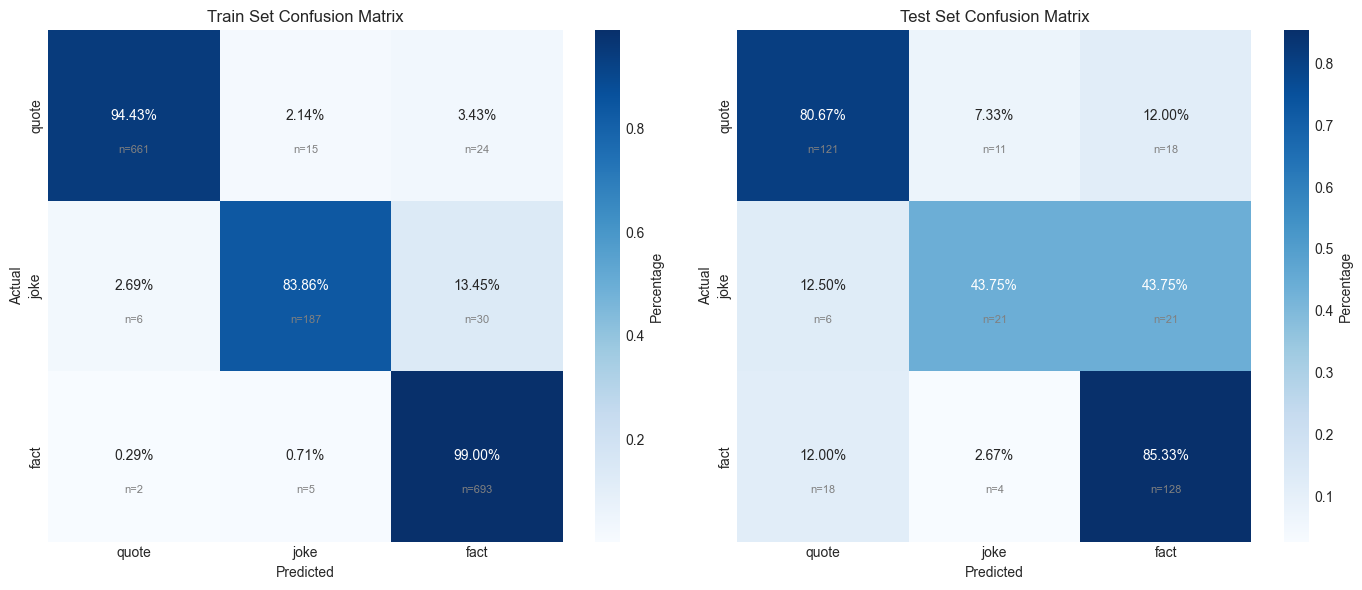

In [54]:
fig2, axes = plt.subplots(1, 2, figsize=(14, 6))
target_names = [config.IDX_TO_LABEL[i] for i in range(config.NUM_CLASSES)]

for ax, (name, preds, labels) in zip(
    axes,
    [('Train', train_preds, train_labels), ('Test', test_preds, test_labels)]
):
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=target_names,
        yticklabels=target_names,
        ax=ax,
        cbar_kws={'label': 'Percentage'}
    )

    for i in range(len(target_names)):
        for j in range(len(target_names)):
            ax.text(j + 0.5, i + 0.7, f'n={cm[i,j]}',
                    ha='center', va='center', fontsize=8, color='gray')

    ax.set_title(f'{name} Set Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()

## Визуализация эмбеддингов

=== t-SNE/PCA ===


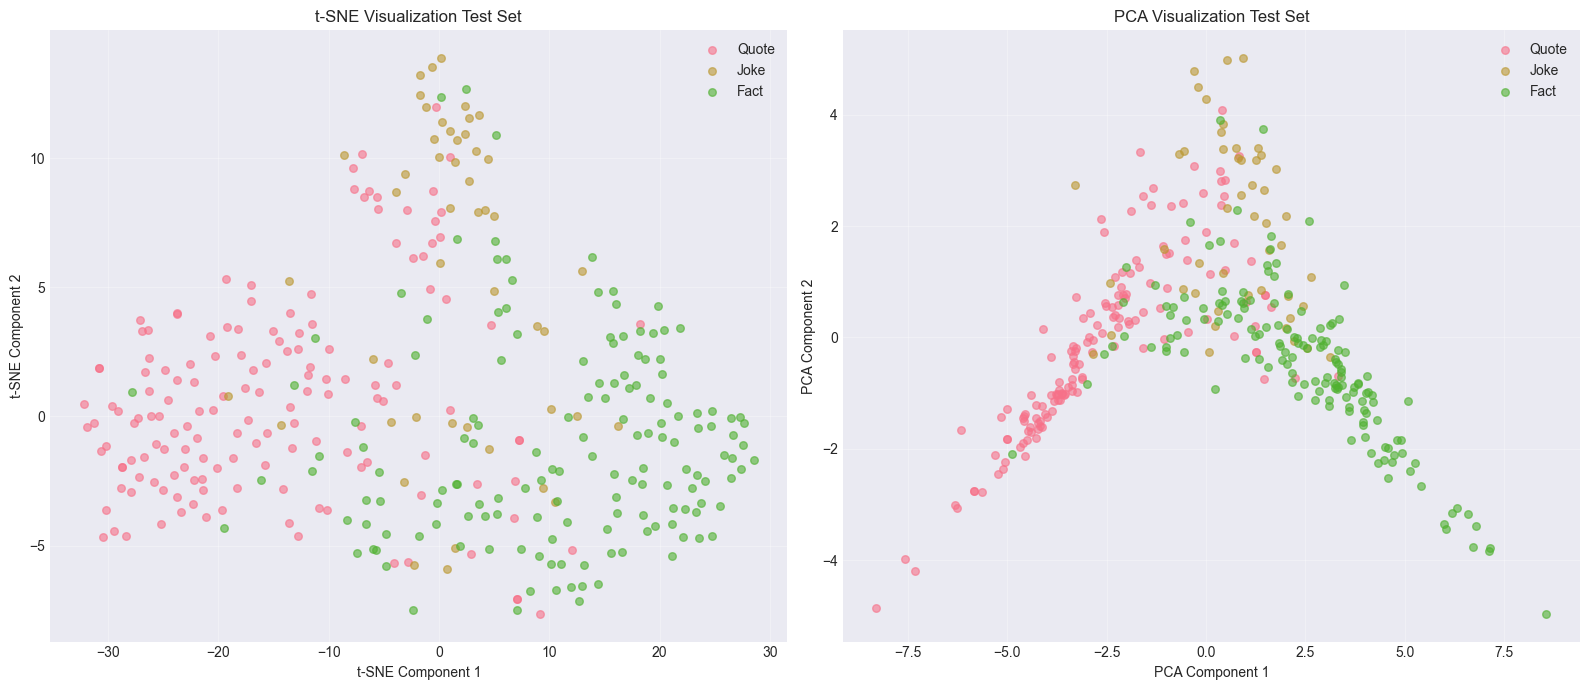

In [55]:
def visualize_embeddings(embeddings, labels, title_suffix=""):
    if embeddings is None or len(embeddings) == 0:
        print("No embeddings to visualize")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    print("=== t-SNE/PCA ===")
    tsne = TSNE(n_components=2, random_state=config.RANDOM_SEED, perplexity=30)
    embeddings_tsne = tsne.fit_transform(embeddings)

    pca = PCA(n_components=2, random_state=config.RANDOM_SEED)
    embeddings_pca = pca.fit_transform(embeddings)

    for ax, data, method in zip(axes, [embeddings_tsne, embeddings_pca], ['t-SNE', 'PCA']):
        for label_idx in range(config.NUM_CLASSES):
            mask = labels == label_idx
            ax.scatter(
                data[mask, 0],
                data[mask, 1],
                label=config.IDX_TO_LABEL[label_idx].capitalize(),
                alpha=0.6,
                s=30
            )

        ax.set_title(f'{method} Visualization {title_suffix}')
        ax.set_xlabel(f'{method} Component 1')
        ax.set_ylabel(f'{method} Component 2')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

visualize_embeddings(test_embeddings, test_labels, "Test Set")

## Инференсы на примерах текстов

In [56]:
@torch.no_grad()
def predict_text(model, text, preprocessor, vocab, device):
    model.eval()

    tokens = preprocessor.preprocess(text)
    indices = vocab.encode(tokens[:config.MAX_SEQ_LENGTH])

    x = torch.tensor([indices], dtype=torch.long).to(device)
    lengths = torch.tensor([len(indices)], dtype=torch.long).to(device)

    outputs = model(x, lengths)
    probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    pred_idx = probs.argmax()
    pred_label = config.IDX_TO_LABEL[pred_idx]

    return pred_label, {config.IDX_TO_LABEL[i]: float(probs[i])
                        for i in range(config.NUM_CLASSES)}

# Демонстрация
examples = [
    "The only way to do great work is to love what you do.",
    "Why don't scientists trust atoms? Because they make up everything!",
    "Honey never spoils. Archaeologists found pots of honey over 3000 years old.",
]
print("\nInference examples:")
for txt in examples:
    label, probs = predict_text(model, txt, preprocessor, vocab, device)
    print(f"Text: {txt}")
    print(f"Prediction: {label}")
    print("Probabilities:")
    for k, v in sorted(probs.items(), key=lambda x: -x[1]):
        print(f"  {k}: {v:.3f}")
    print("-")



Inference examples:
Text: The only way to do great work is to love what you do.
Prediction: quote
Probabilities:
  quote: 0.995
  fact: 0.003
  joke: 0.002
-
Text: Why don't scientists trust atoms? Because they make up everything!
Prediction: quote
Probabilities:
  quote: 0.527
  joke: 0.357
  fact: 0.116
-
Text: Honey never spoils. Archaeologists found pots of honey over 3000 years old.
Prediction: fact
Probabilities:
  fact: 0.977
  joke: 0.017
  quote: 0.006
-
